In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.ops import nearest_points

In [2]:
bh = gpd.read_file("../bh_lago_paranoa.geojson").dissolve().to_crs(4674)
bh_buf_1000 = bh.copy()
bh_buf_1000 = bh_buf_1000.to_crs("EPSG:31983")
bh_buf_1000.geometry = bh_buf_1000.geometry.buffer(1000)
bh_buf_1000  = bh_buf_1000.to_crs("EPSG:4674")

bh_buf_30 = bh.copy()
bh_buf_30 = bh_buf_30.to_crs("EPSG:31983")
bh_buf_30.geometry = bh_buf_30.geometry.buffer(30)
bh_buf_30 = bh_buf_30.to_crs("EPSG:4674")

xmin, ymin, xmax, ymax = bh_buf_1000.total_bounds
bbox = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])
gdf_bbox = gpd.GeoDataFrame(geometry = [bbox]).set_crs(4674)

In [3]:
years = [str(y) for y in range(1985, 2024)]
meses = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
dias_por_mes = {'jan': 31, 'feb': 28, 'mar': 31, 'apr': 30, 'may': 31, 'jun': 30, 'jul': 31, 'aug': 31, 'sep': 30, 'oct': 31, 'nov': 30, 'dec': 31}


In [4]:
geom_estacoes = gpd.read_file("./dados_pluviometricos/estacoes_pluv_ana_com_dados.geojson")

In [7]:
## teste da consistencia

In [8]:
na_counts_df_list = []
for year in years:
    data_year = pd.read_csv(f"./dados_pluviometricos/{year}/dados_pluv_ana_{year}.csv")
    data_year_12 = data_year.groupby('EstacaoCodigo').filter(lambda x: len(x) == 12)
    data_year_12['Data'] = pd.to_datetime(data_year['Data'], format='%d/%m/%Y')

    
    data_year_12['mes'] = data_year_12['Data'].dt.month.apply(lambda x: meses[x-1])

    for est in list(data_year_12.EstacaoCodigo.unique()):
        data_year_12_est = data_year_12[data_year_12.EstacaoCodigo == est]
        na_counts = data_year_12_est[
            ['Chuva01', 'Chuva02', 'Chuva03', 'Chuva04', 'Chuva05',
             'Chuva06', 'Chuva07', 'Chuva08', 'Chuva09', 'Chuva10', 'Chuva11',
             'Chuva12', 'Chuva13', 'Chuva14', 'Chuva15', 'Chuva16', 'Chuva17',
             'Chuva18', 'Chuva19', 'Chuva20', 'Chuva21', 'Chuva22', 'Chuva23',
             'Chuva24', 'Chuva25', 'Chuva26', 'Chuva27', 'Chuva28', 'Chuva29',
             'Chuva30', 'Chuva31']
        ].isna().sum(axis=1)

        est_na_df = pd.DataFrame({
            'EstacaoCodigo': est,
            'ano': year,
            'mes': data_year_12_est['mes'].values,
            'qtd_na': na_counts.values
        })
        na_counts_df_list.append(est_na_df)


na_counts_df = pd.concat(na_counts_df_list, ignore_index=True)
pivot_na_counts = na_counts_df.pivot_table(index=['EstacaoCodigo', "ano"], columns='mes', values='qtd_na', aggfunc='first').reset_index()
pivot_na_counts['soma_na'] = pivot_na_counts[meses].sum(axis=1)

In [9]:
for year in years: 
    os.makedirs(f"./dados_pluviometricos/{year}/", exist_ok = True)
    data_year = pd.read_csv(f"./dados_pluviometricos/{year}/dados_pluv_ana_{year}.csv")
    data_year_12 = data_year.groupby('EstacaoCodigo').filter(lambda x: len(x) == 12)
    data_year_12['Data'] = pd.to_datetime(data_year['Data'], format='%d/%m/%Y')
    data_year_12['Mes'] = data_year_12['Data'].dt.month.apply(lambda x: meses[x-1])
    break


In [12]:
## nao pode faltar mais do que 10 dias no mês e nem 5 dias consecutivos
## https://library.wmo.int/records/item/55797-wmo-guidelines-on-the-calculation-of-climate-normals

def get_valid_chuva_cols(mes):
    dias = dias_por_mes[mes]
    return [f'Chuva{str(i).zfill(2)}' for i in range(1, dias + 1)]
def should_remove_row(row):
    mes = row['Mes']
    chuva_cols = get_valid_chuva_cols(mes)
    # Condição 1: mais de 10 NaNs
    nan_count = row[chuva_cols].isna().sum()
    if nan_count > 10:
        return True

    # Condição 2: 5 ou mais NaNs consecutivos
    count = 0
    for col in chuva_cols:
        if pd.isna(row[col]):
            count += 1
            if count >= 5:
                return True
        else:
            count = 0
    
    return False

In [ ]:
for year in years: 
    os.makedirs(f"./dados_pluviometricos/{year}/", exist_ok = True)
    data_year = pd.read_csv(f"./dados_pluviometricos/{year}/dados_pluv_ana_{year}.csv")

    ## consistencia
    data_year_12 = data_year.groupby('EstacaoCodigo').filter(lambda x: len(x) == 12)
    data_year_12['Data'] = pd.to_datetime(data_year['Data'], format='%d/%m/%Y')
    data_year_12 = data_year_12.rename(columns={'EstacaoCodigo': 'cz_id'})

    mask_to_remove = data_year_12.apply(should_remove_row, axis=1)
 #   display(data_year_12[mask_to_remove])
    data_year_consistent = data_year_12[~mask_to_remove].reset_index(drop=True)
    data_year_12_consistent = data_year_consistent.groupby('cz_id').filter(lambda x: len(x) == 12)

    pivot_data_year_12 = data_year_12_consistent.pivot_table(index='cz_id', columns='Mes', values='NumDiasDeChuva_0_1', aggfunc='first').reset_index()
    pivot_data_year_12['cz_id'] = pivot_data_year_12['cz_id'].astype(int)
    pivot_data_year_12 = pivot_data_year_12[['cz_id'] + meses]
    pivot_data_year_12[meses] = pivot_data_year_12[meses].astype(int)
    pivot_data_year_12.to_csv(f"./dados_pluviometricos/{year}/climate_zone.csv", index = False)
    gdf_estacoes = geom_estacoes[geom_estacoes["EstacaoCodigo"].isin(pivot_data_year_12.cz_id.unique())][["EstacaoCodigo", "geometry"]].drop_duplicates().reset_index(drop=True)
    gdf_estacoes.to_file(f"./dados_pluviometricos/{year}/climate_zone_points.geojson")

In [18]:
for year in years:
    temp = gpd.read_file(f"./dados_pluviometricos/{year}/climate_zone_points.geojson").sort_values("EstacaoCodigo")
    print(year, len(temp))


1985 17
1986 15
1987 16
1988 16
1989 17
1990 17
1991 16
1992 16
1993 17
1994 17
1995 18
1996 18
1997 16
1998 17
1999 18
2000 18
2001 18
2002 18
2003 19
2004 19
2005 19
2006 18
2007 16
2008 22
2009 21
2010 27
2011 17
2012 11
2013 20
2014 7
2015 16
2016 7
2017 19
2018 17
2019 12
2020 16
2021 8
2022 16
2023 13


In [24]:
def voronoi_polygons(vor, bbox):
    polygons = []
    for region in vor.regions:
        if len(region) > 0 and -1 not in region: 
            polygon = [vor.vertices[i] for i in region]
            polygon = Polygon(polygon)
            if polygon.intersects(bbox):
                polygon = polygon.intersection(bbox)
                if polygon.is_valid:
                    polygons.append(polygon)
    return polygons


def rasterize_polygons(gdf, column_band, output_file):

    gdf_raster = make_geocube(
        vector_data=gdf,
        measurements=[column_band],
        resolution=(-30, 30),
        fill = 0
    )
    gdf_raster.rio.to_raster(output_file)

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


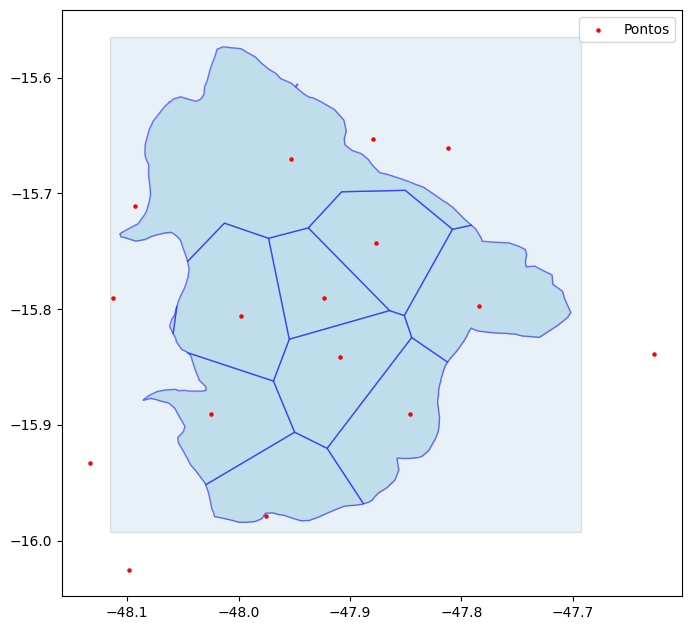

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


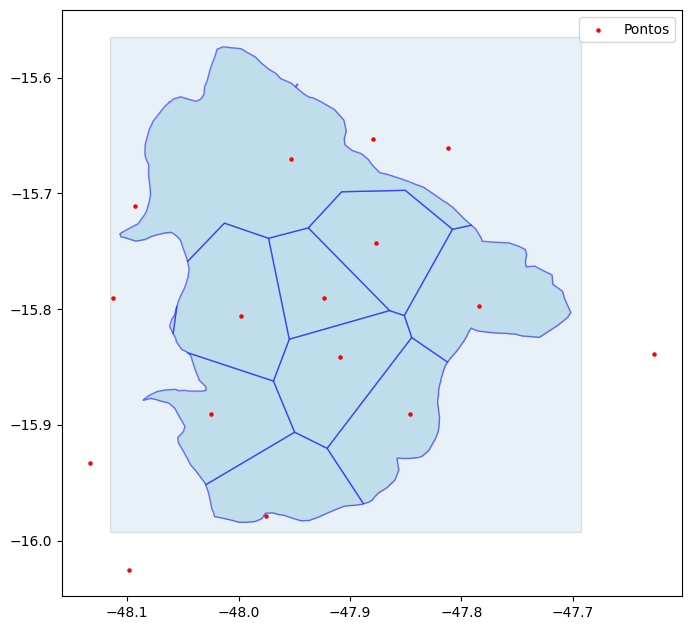

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


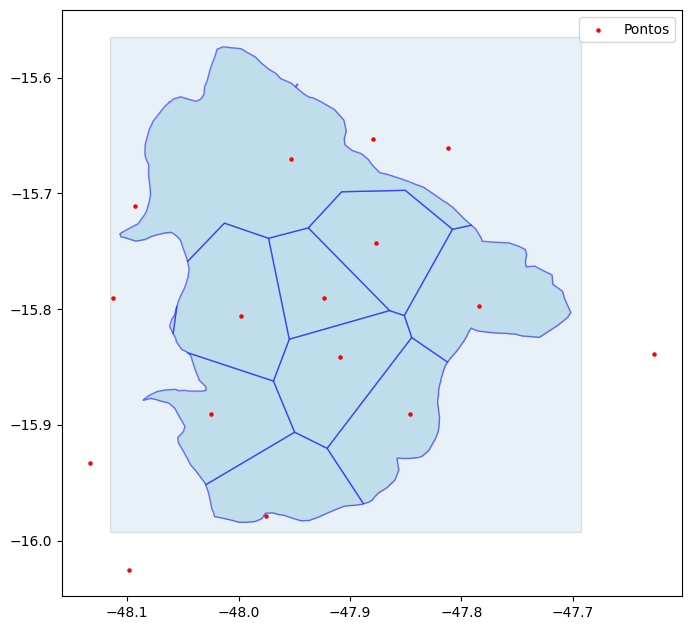

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


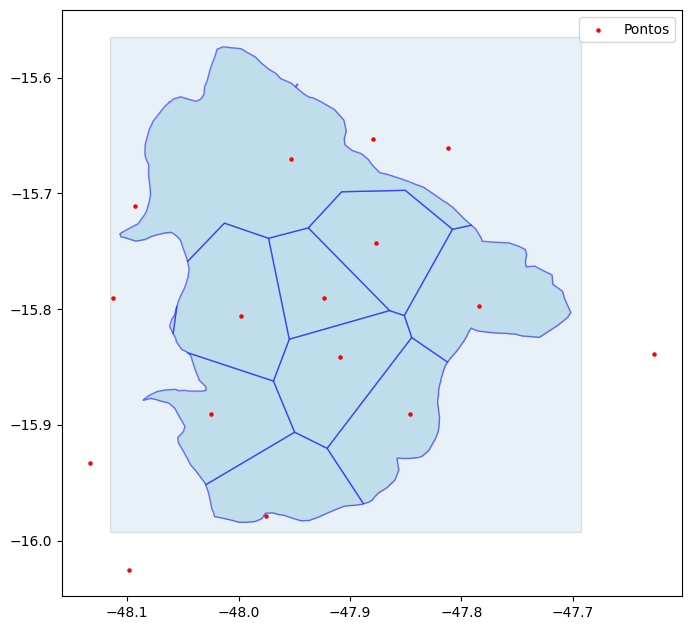

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


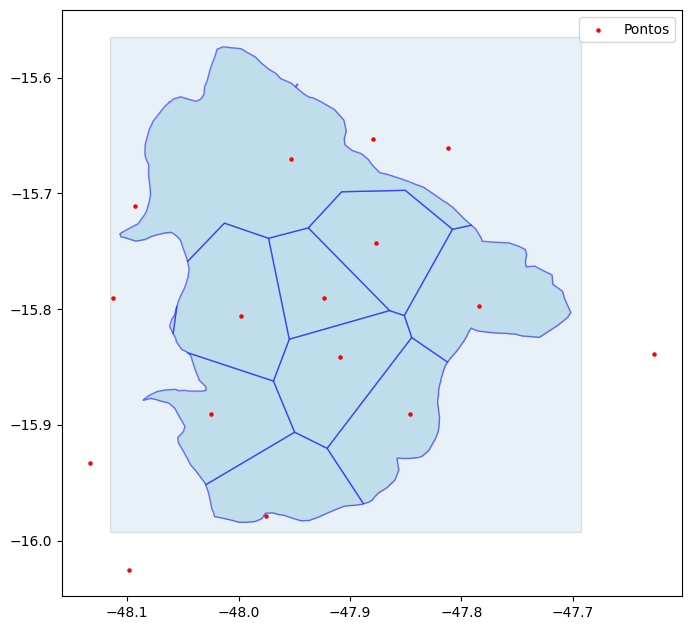

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


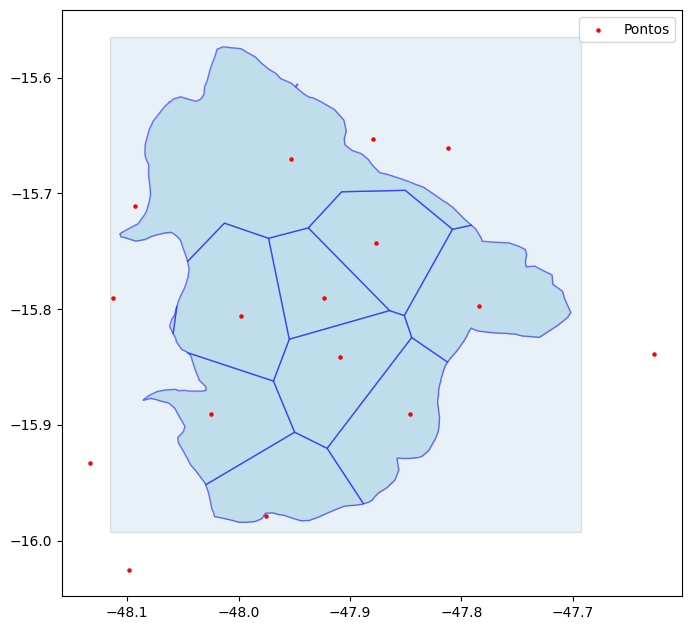

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


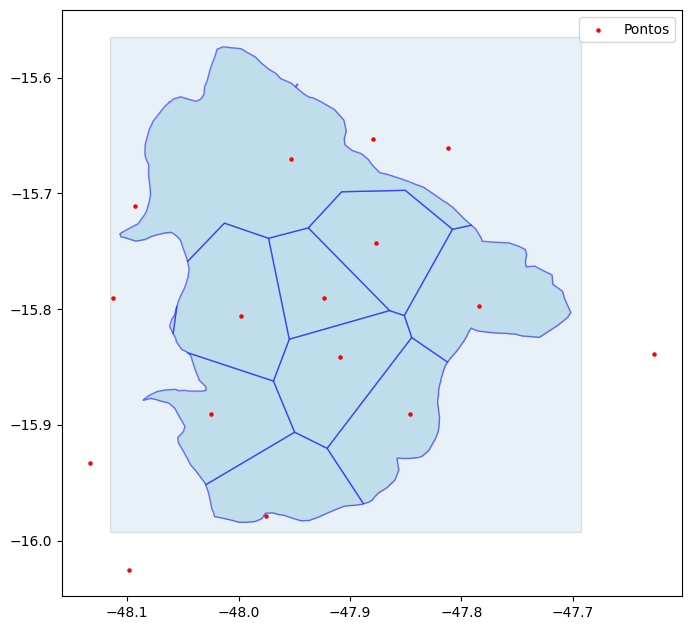

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


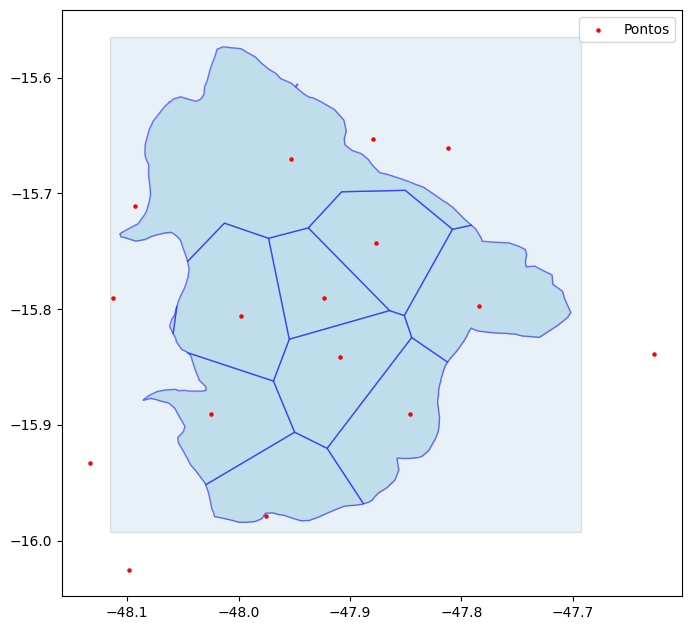

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


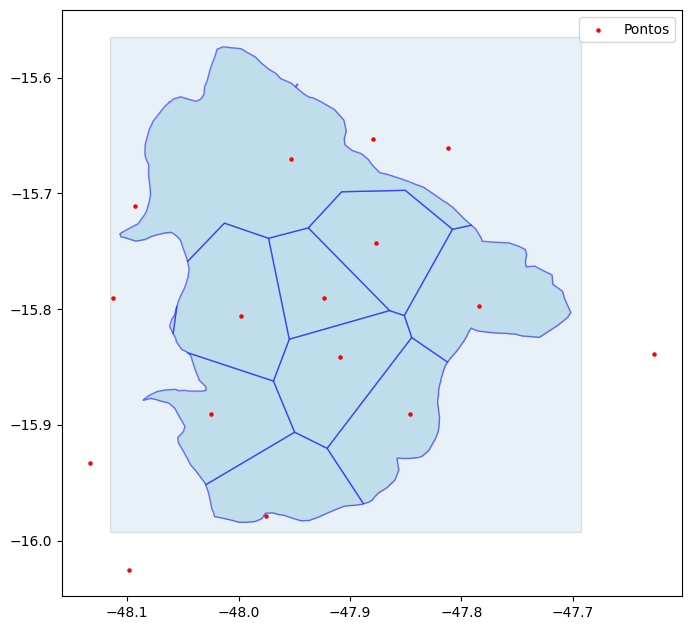

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


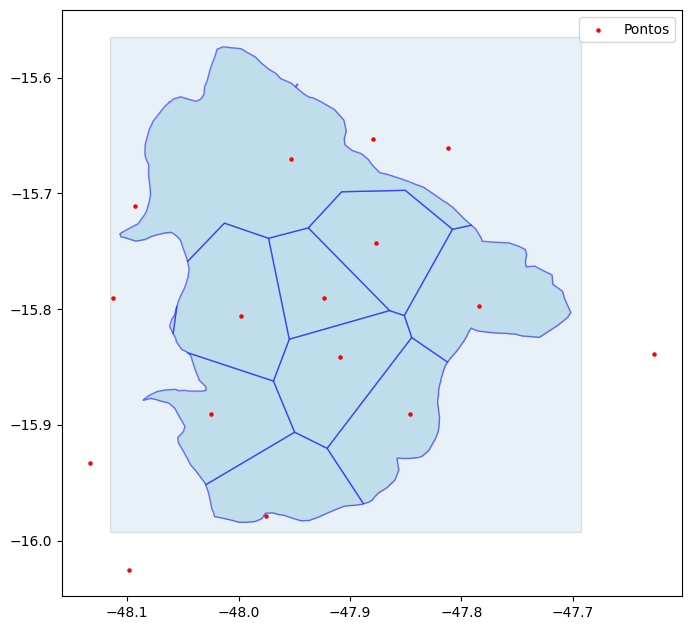

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


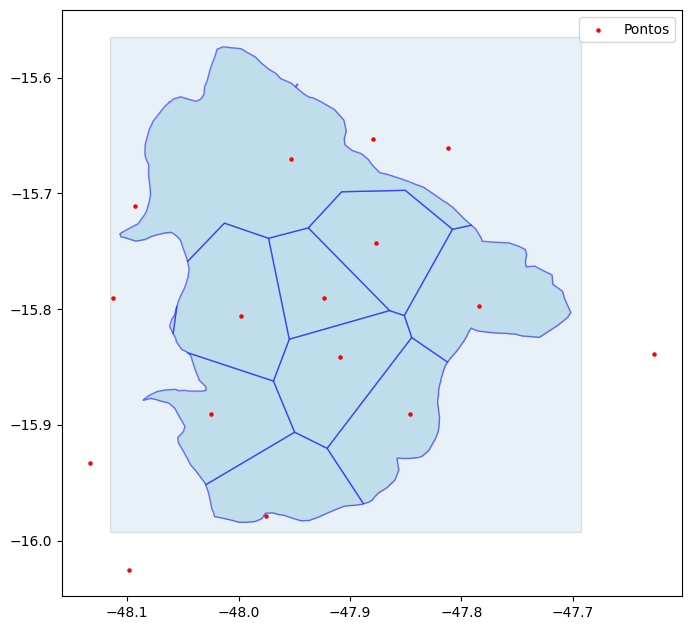

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


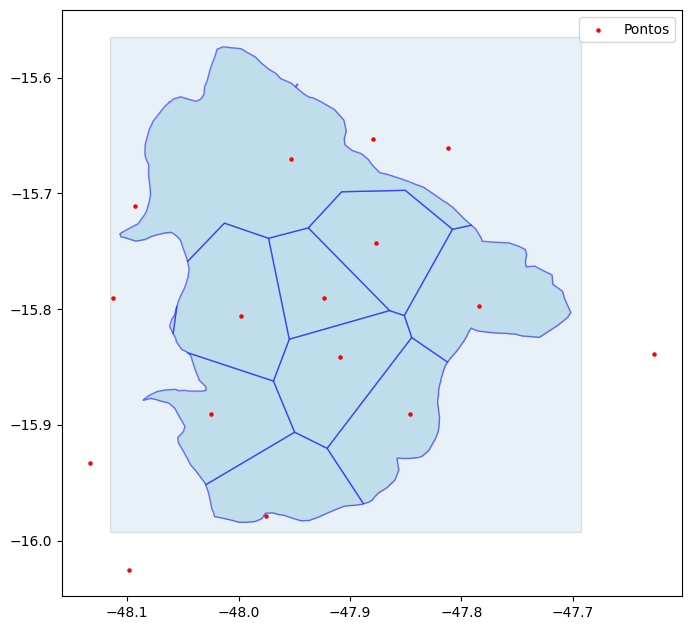

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


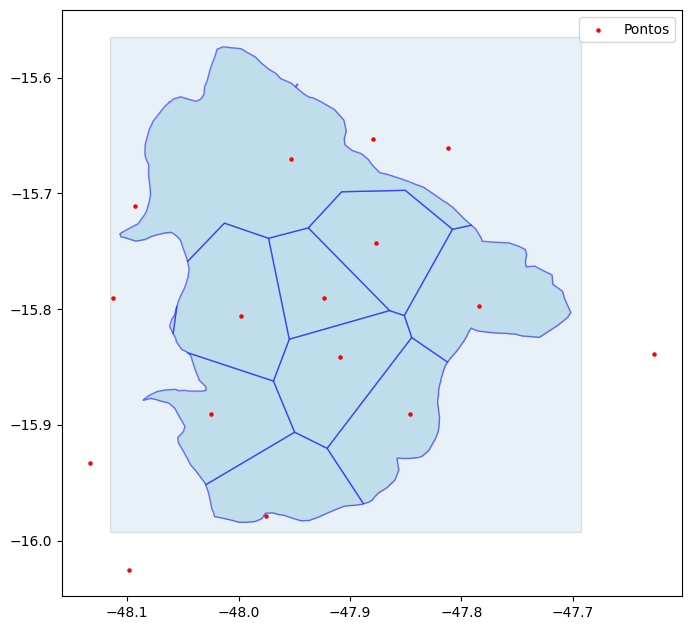

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


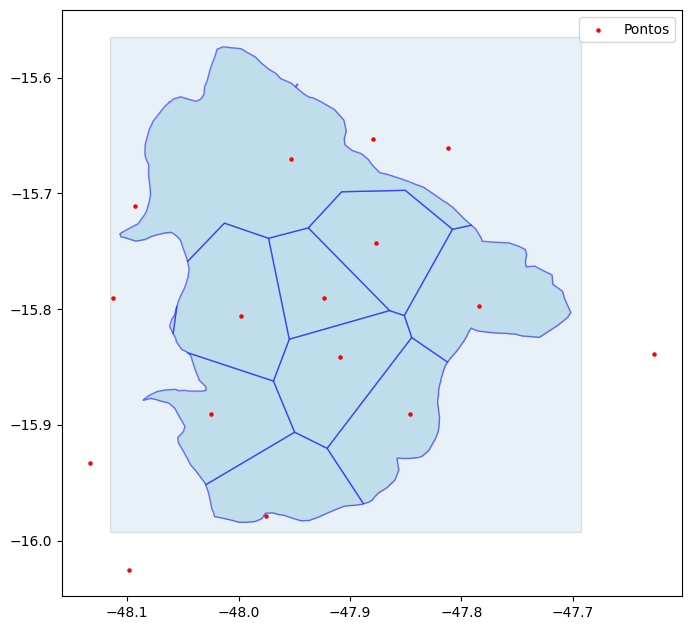

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


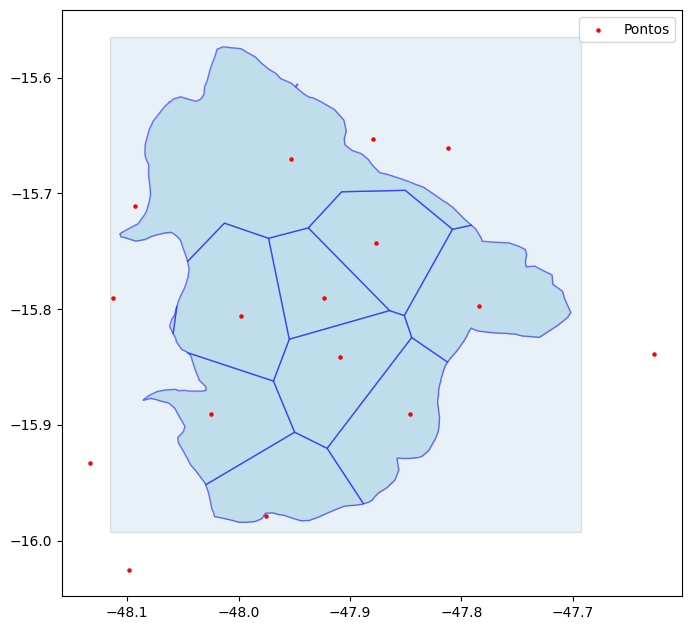

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


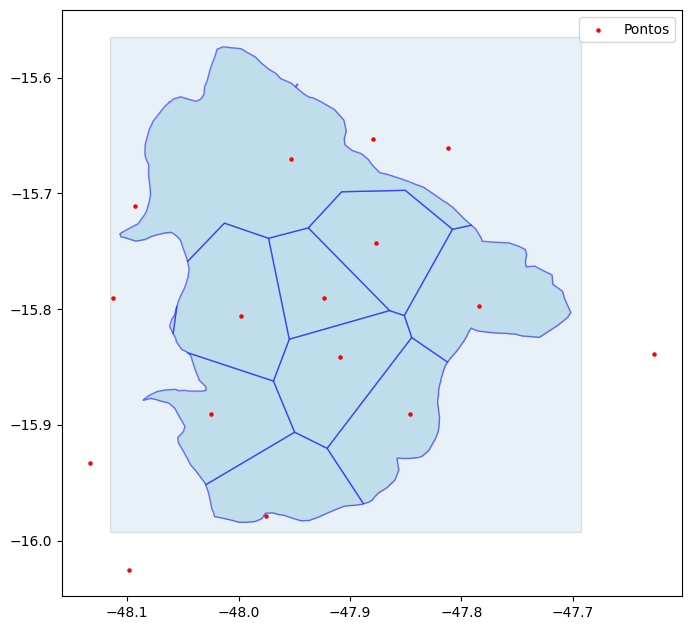

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


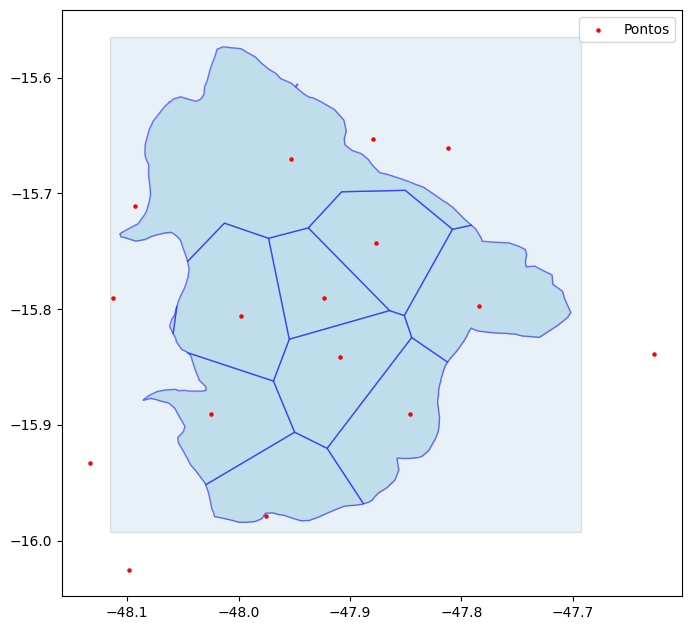

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


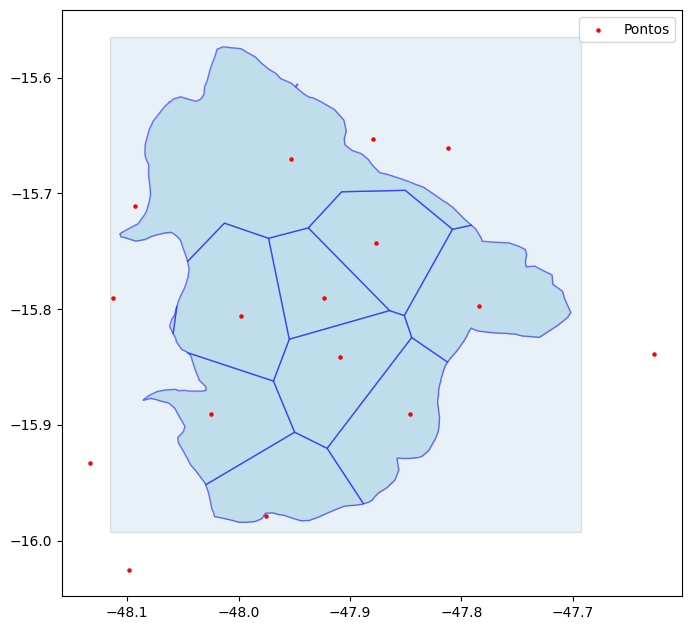

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


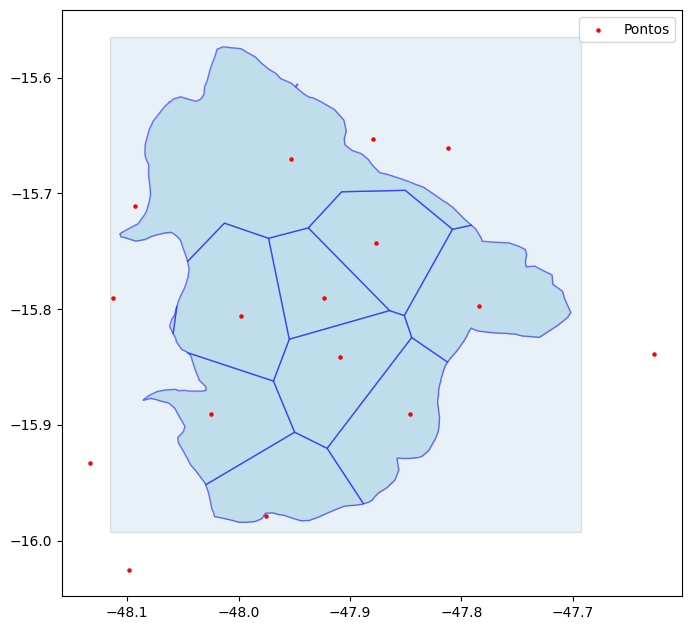

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


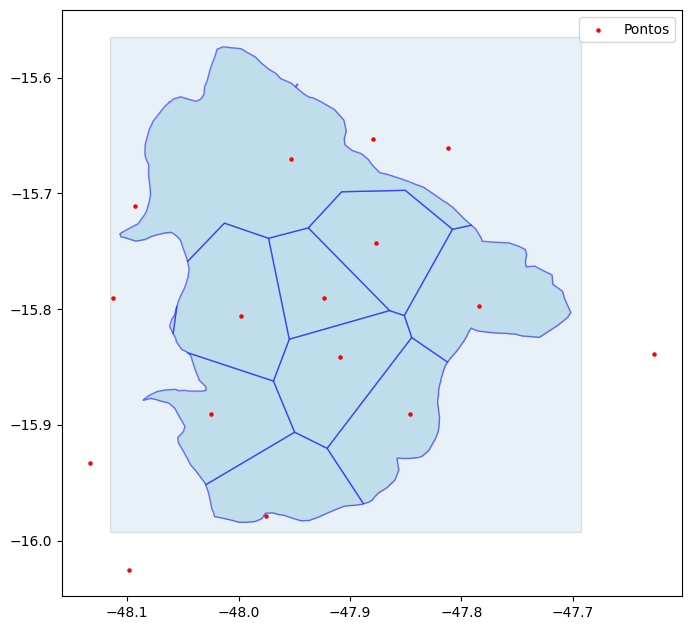

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


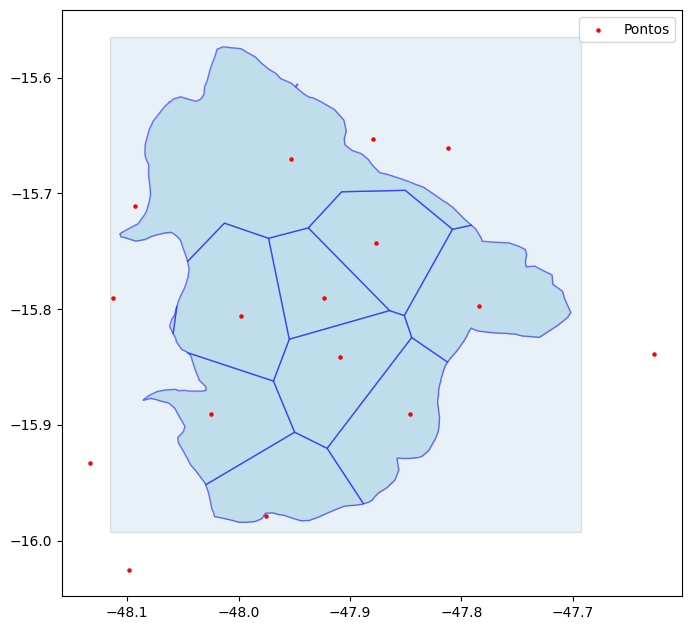

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


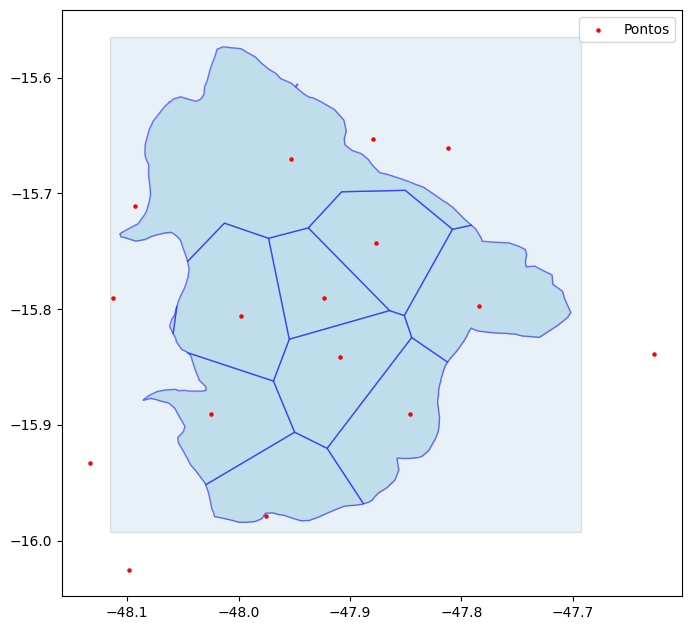

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


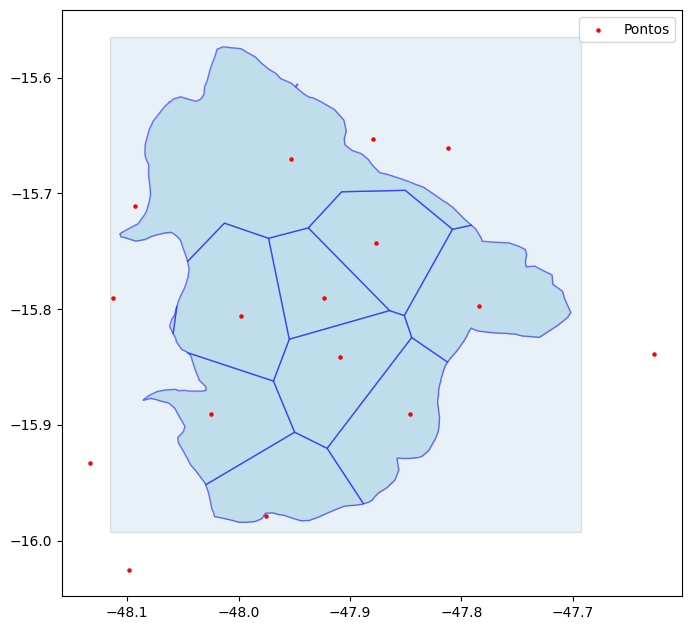

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


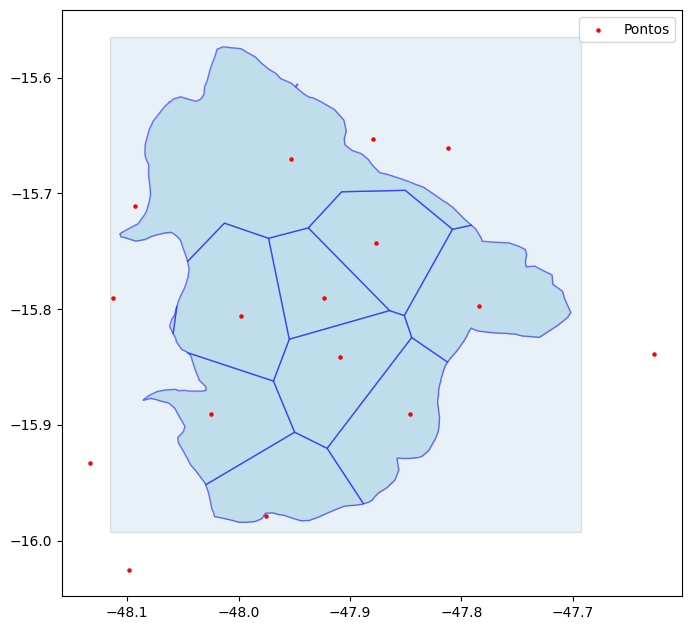

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


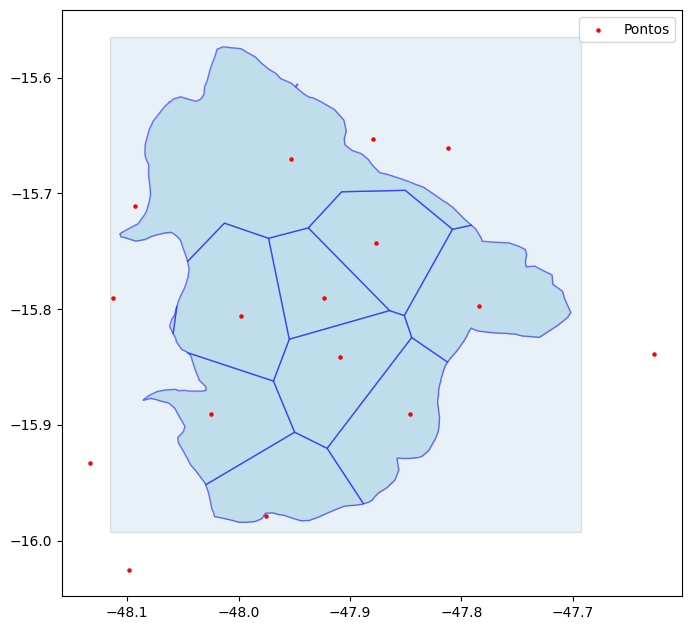

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


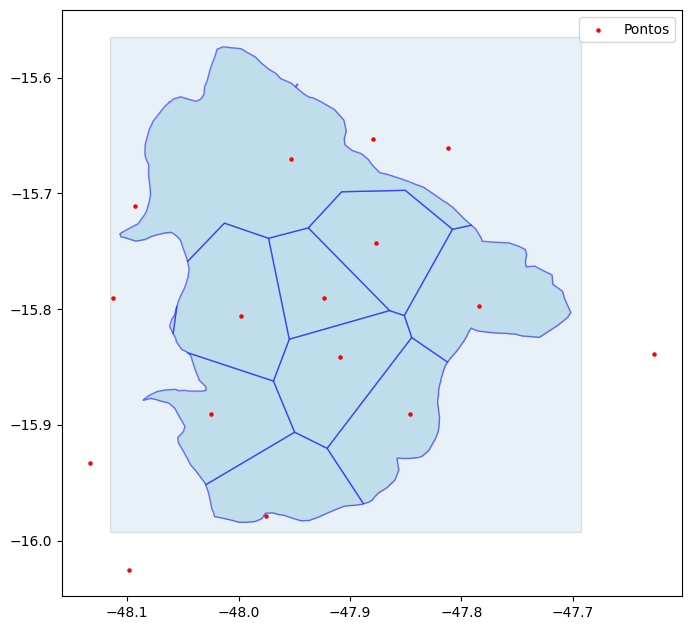

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


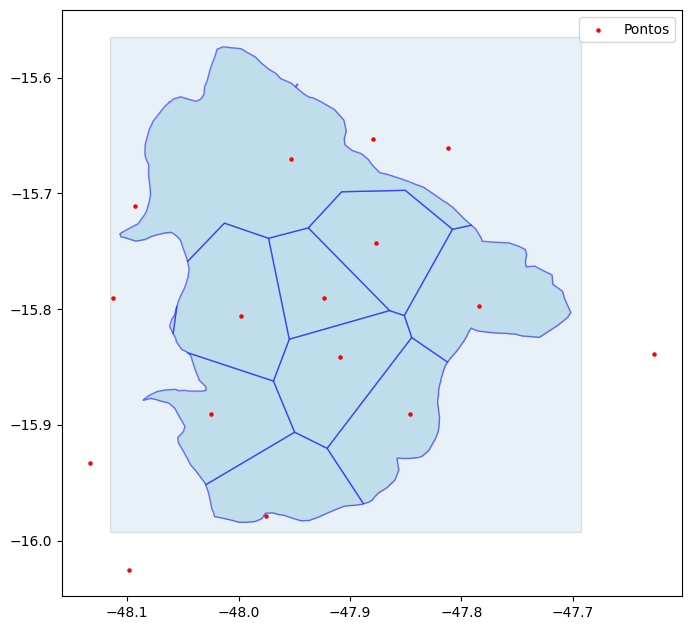

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


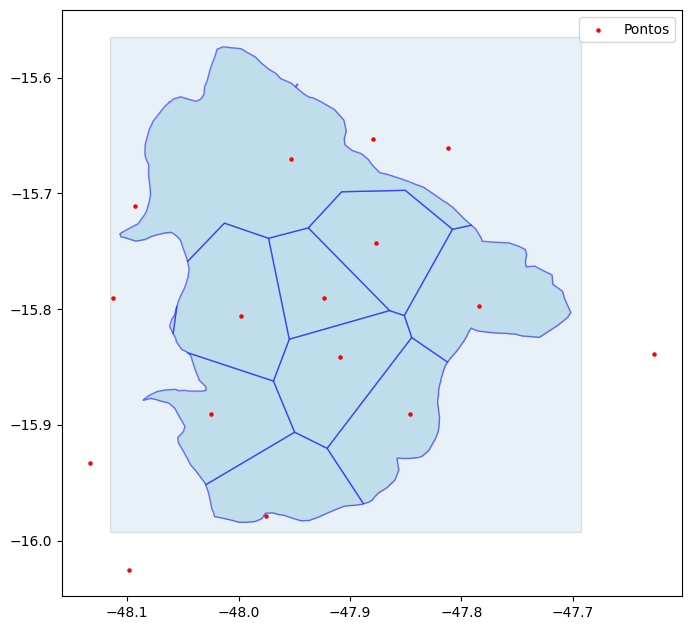

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


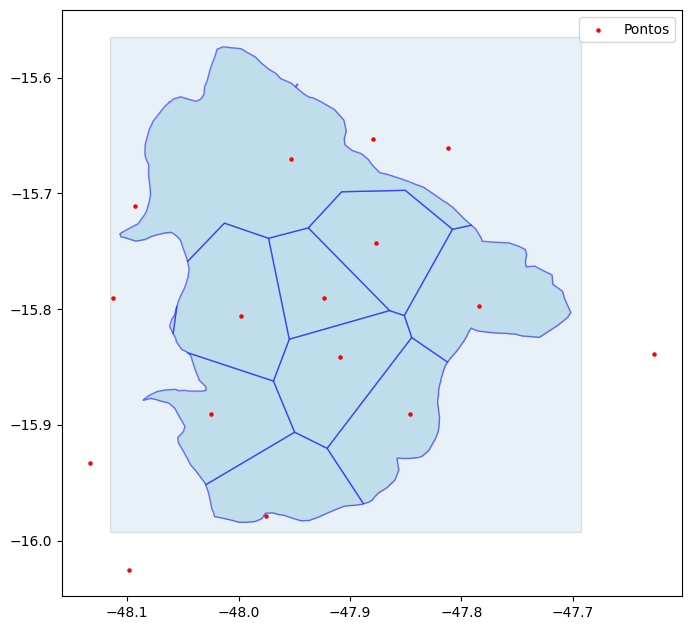

/tmp/ipykernel_1232/1492705536.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  estacoes_geom = gdf_estacoes.geometry.unary_union
/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


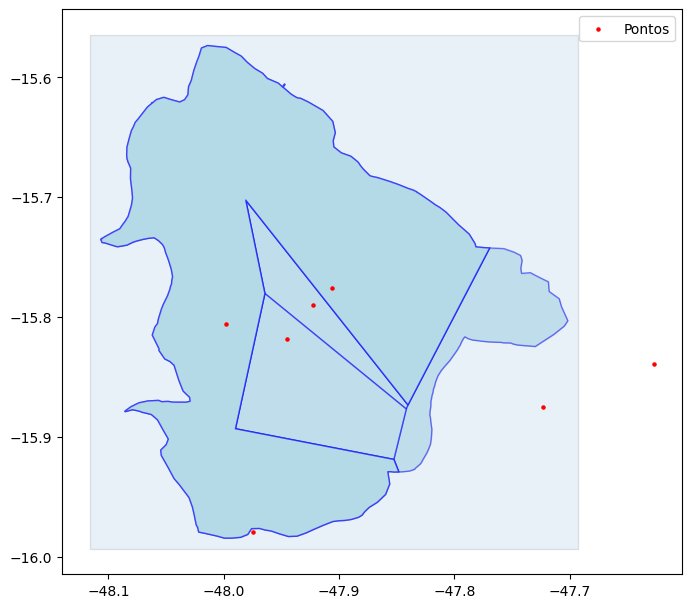

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


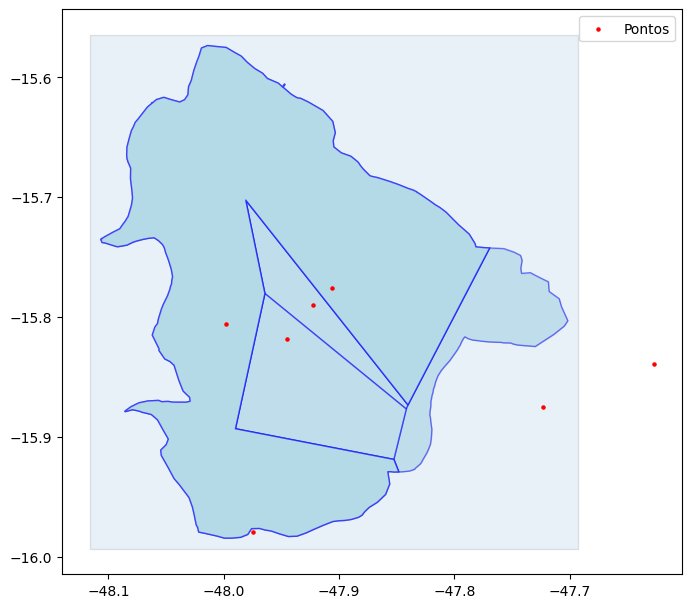

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


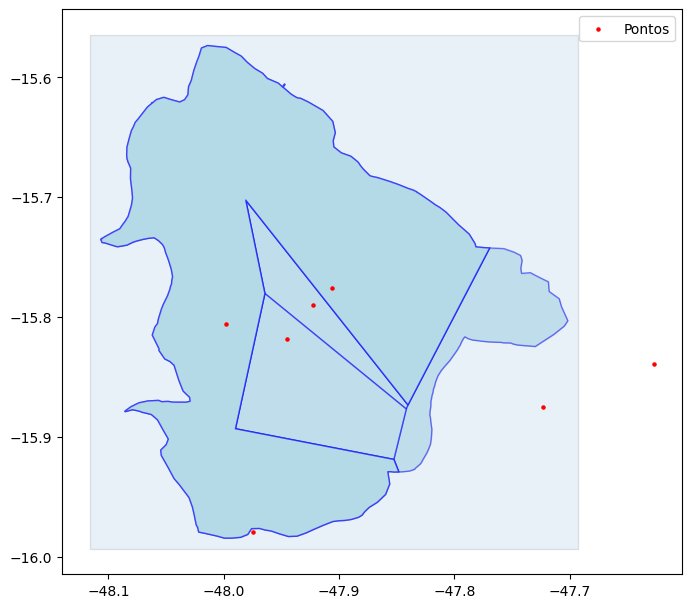

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


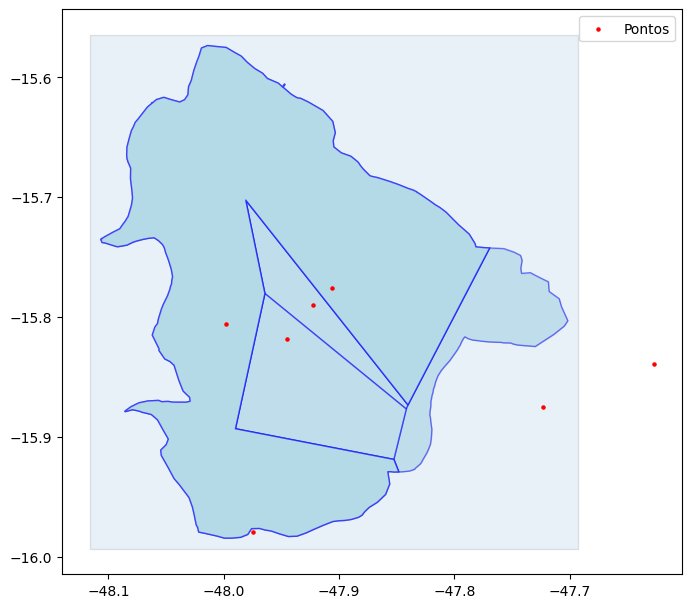

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


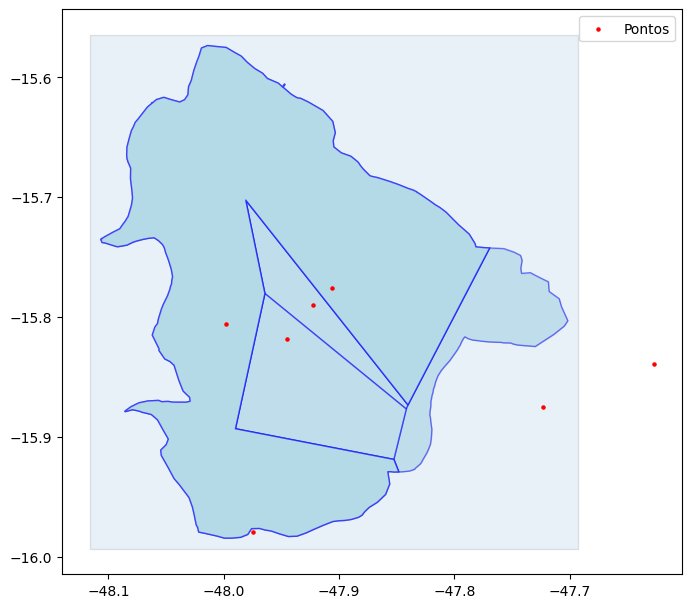

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


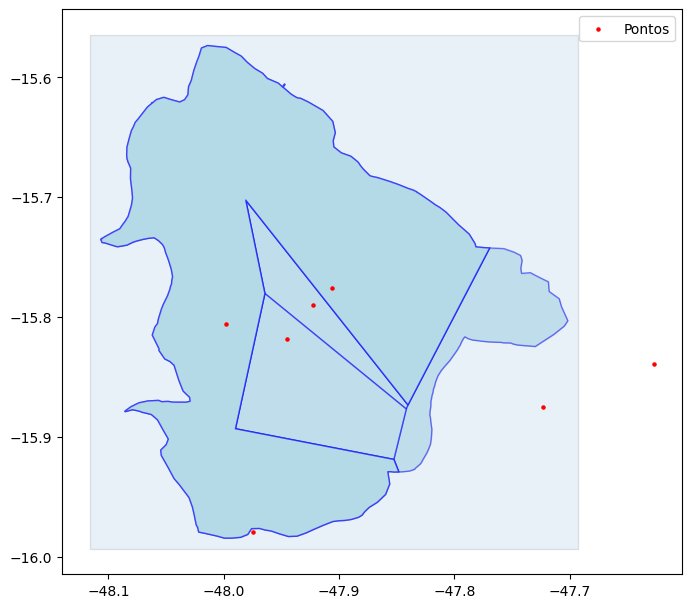

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


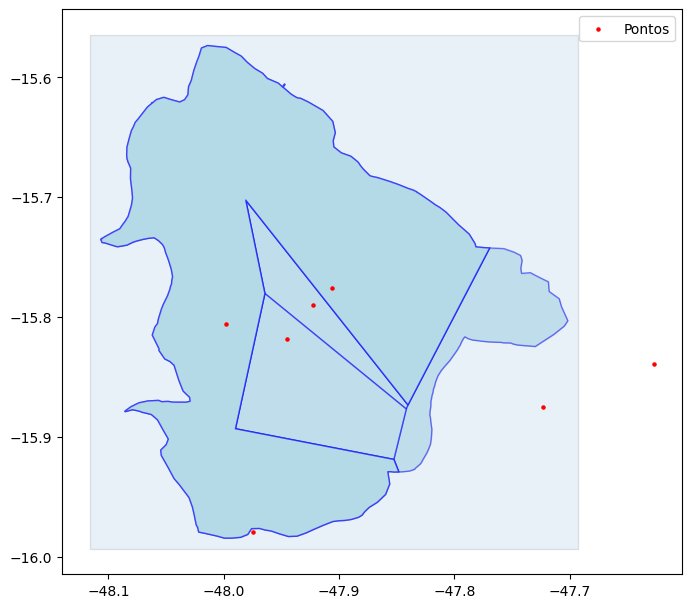

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


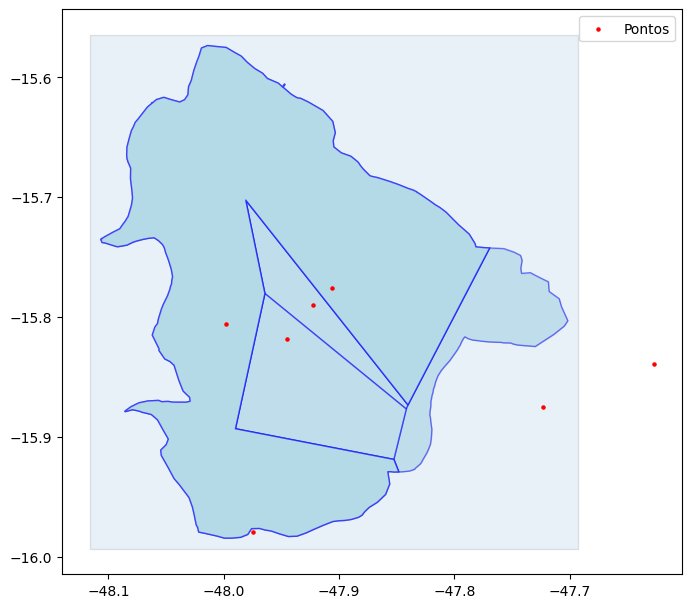

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


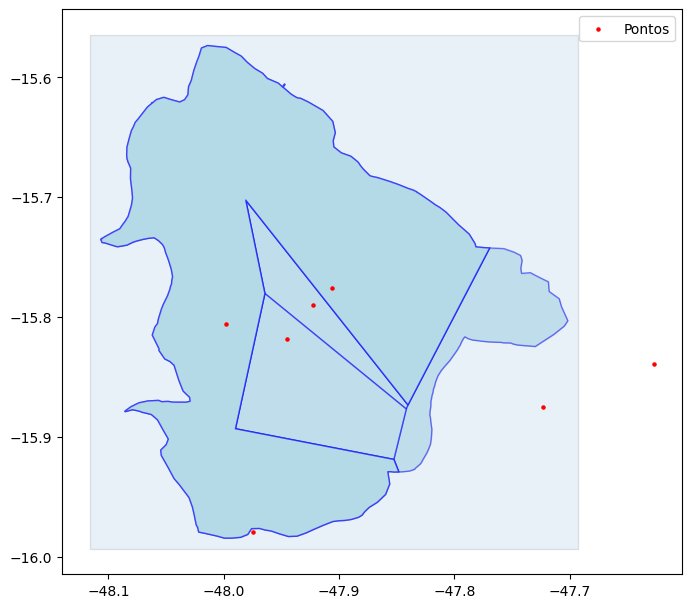

/tmp/ipykernel_1232/1492705536.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


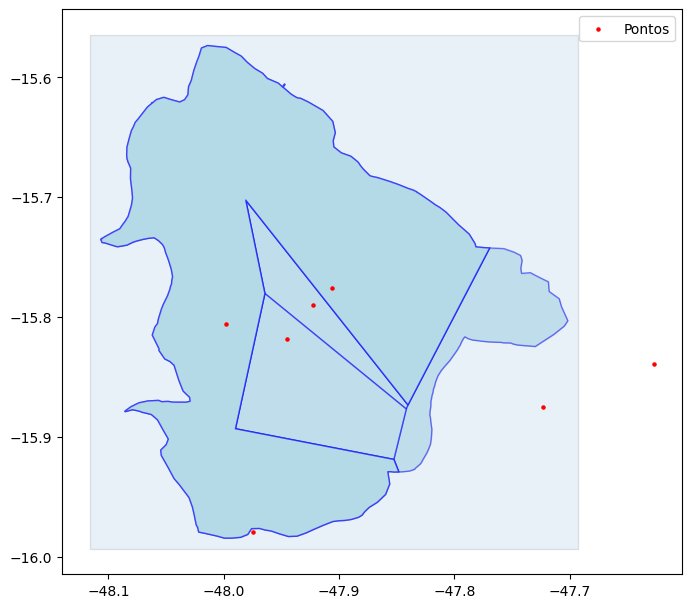

In [27]:
for year in years:
    if year == "2014":
        gdf_estacoes = gpd.read_file(f"./dados_pluviometricos/{year}/climate_zone_points.geojson")
        
        coords = np.array([(point.x, point.y) for point in gdf_estacoes.geometry])
        vor = Voronoi(coords)
        polygons = voronoi_polygons(vor, bbox)
        gdf_voronoi = gpd.GeoDataFrame(geometry=polygons).set_crs(4674)
        dif_bbox_vor = gpd.overlay(gdf_bbox, gdf_voronoi, how = "difference").explode()
        all_vor = gpd.GeoDataFrame(pd.concat([gdf_voronoi, dif_bbox_vor]))
        bh_voronoi = gpd.overlay(bh_buf_30[["geometry"]], all_vor, how = "intersection")
        gdf_voronoi_est = bh_voronoi.sjoin(gdf_estacoes, how = "left").drop("index_right", axis = 1)
        gdf_voronoi_est = gdf_voronoi_est.explode().reset_index(drop=True)
        
        # Identificamos os polígonos que não tiveram correspondência
        sem_estacao = gdf_voronoi_est[gdf_voronoi_est.EstacaoCodigo.isna()]
        # Se houver polígonos sem estação
        if not sem_estacao.empty:
            # Para cada polígono sem estação, encontramos a estação mais próxima
            for idx, poligono in sem_estacao.iterrows():
                # Calcula o ponto mais próximo
                poligono_geom = poligono.geometry
                estacoes_geom = gdf_estacoes.geometry.unary_union
                ponto_proximo = nearest_points(poligono_geom, estacoes_geom)[1]
                
                # Encontra a estação correspondente ao ponto mais próximo
                estacao_mais_proxima = gdf_estacoes[gdf_estacoes.geometry == ponto_proximo]
                # Se encontrou a estação mais próxima
                if not estacao_mais_proxima.empty:
                    # Atualiza o DataFrame original com os dados da estação mais próxima
                    cols_to_update = gdf_estacoes.columns.difference(['geometry'])
                    for col in cols_to_update:
                        gdf_voronoi_est.loc[idx, col] = estacao_mais_proxima[col].values[0]
        
        # Remove a coluna temporária index_right se ainda existir
        if 'index_right' in gdf_voronoi_est.columns:
            gdf_voronoi_est = gdf_voronoi_est.drop('index_right', axis=1)
            
        bh_voronoi = gpd.overlay(bh_buf_30[["geometry"]], gdf_voronoi_est, how = "intersection")
        bh_voronoi.to_file(f"./dados_pluviometricos/{year}/climate_zone_voronoi.geojson")
       # print(len(bh_voronoi), len(list(bh_voronoi.EstacaoCodigo.unique())))
        rasterize_polygons(bh_voronoi.to_crs(31983), 'EstacaoCodigo', f"./dados_pluviometricos/{year}/climate_zone.tif")
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    gdf_bbox.plot(ax=ax, edgecolor='black', alpha=0.1)
    bh.plot(ax=ax, edgecolor='black', alpha=0.1)
    bh_voronoi.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5, label='Voronoi Polygons')
    gdf_estacoes.plot(ax=ax, color='red', markersize=5, label='Pontos')
    plt.legend()
    plt.show()


1985


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


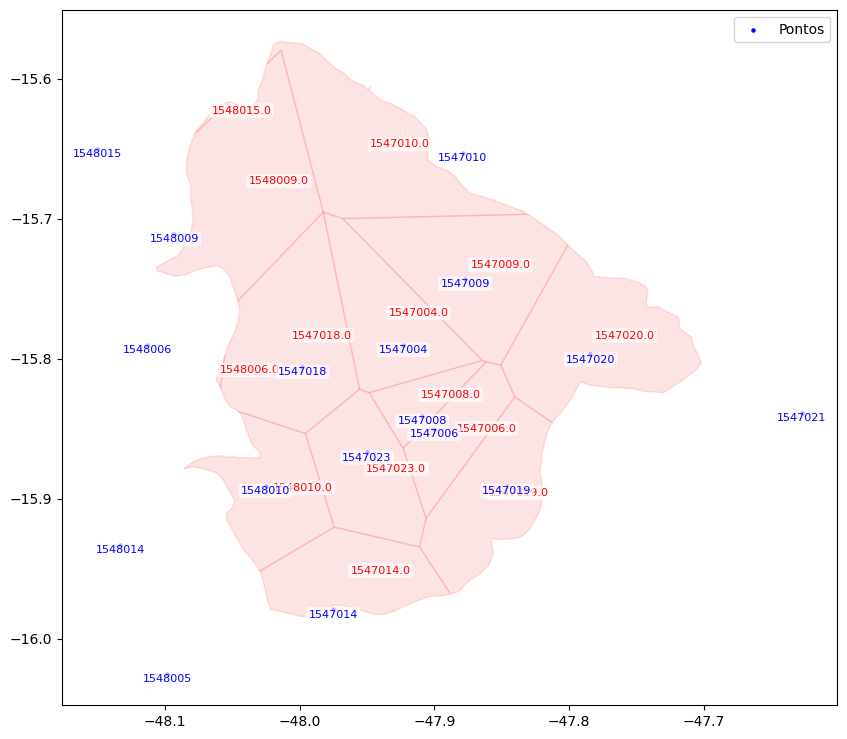

1986


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


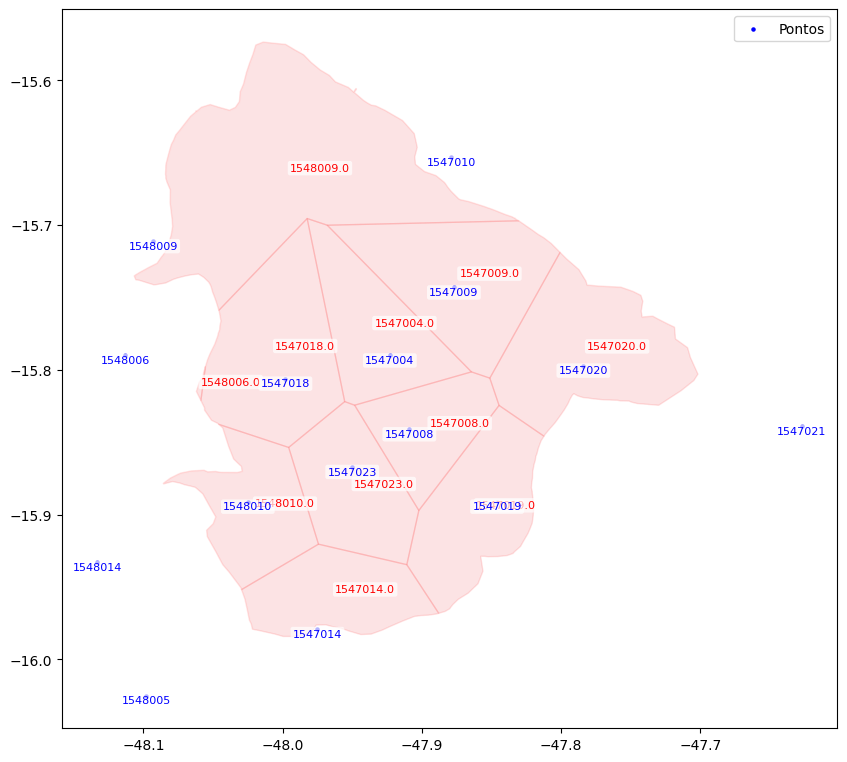

1987


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


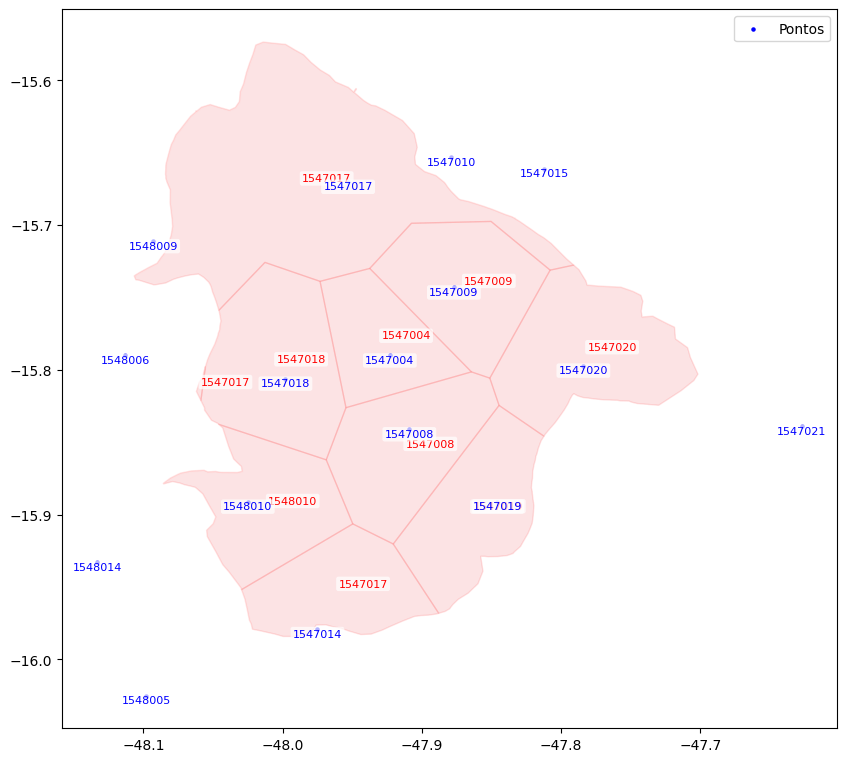

1988


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


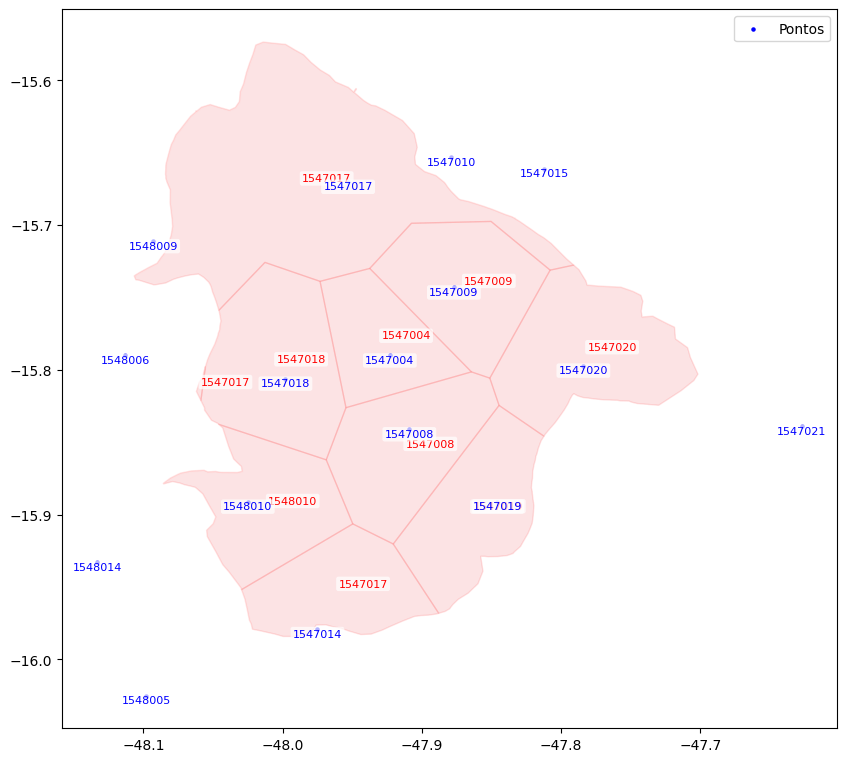

1989


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


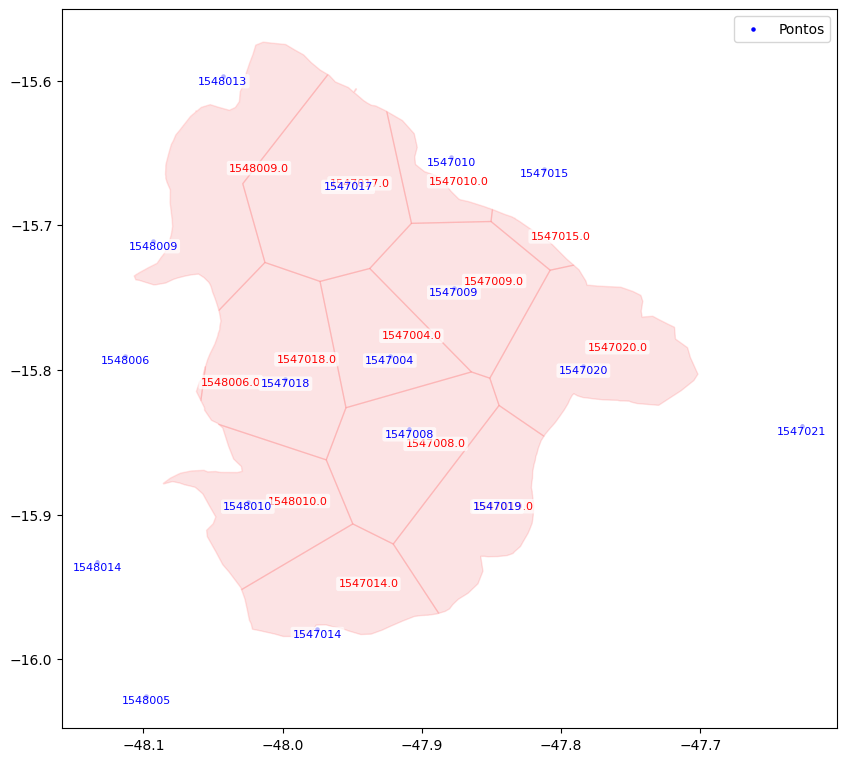

1990


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


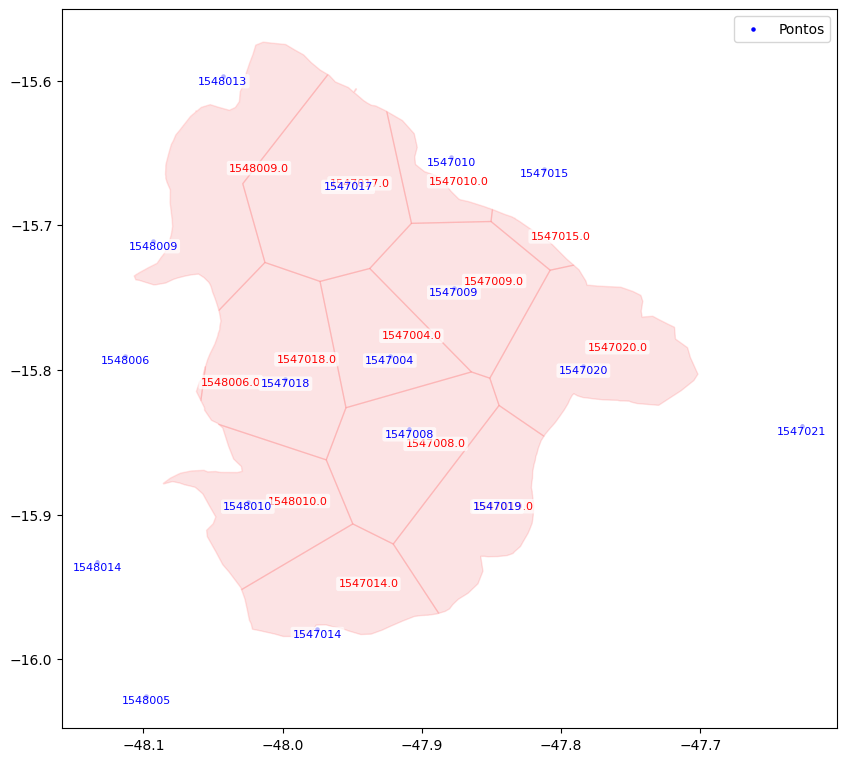

1991


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


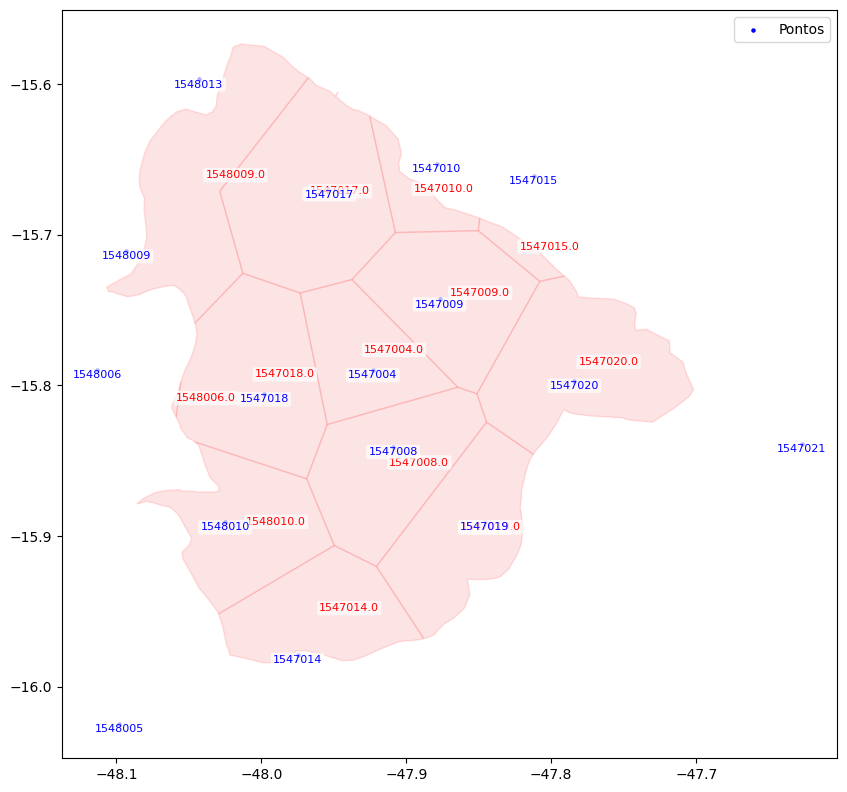

1992


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


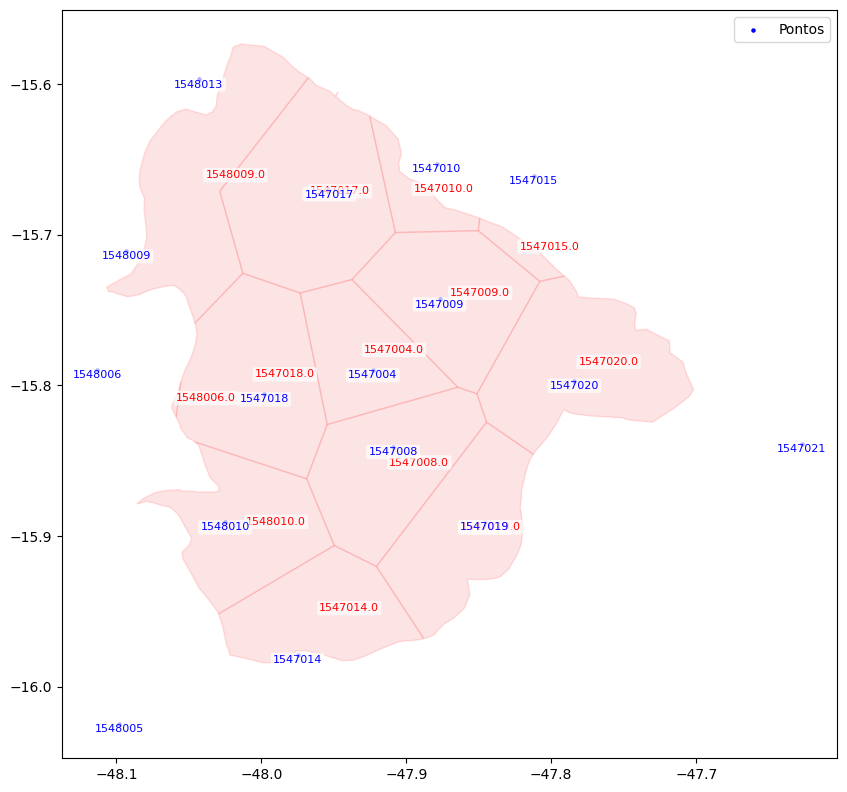

1993


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


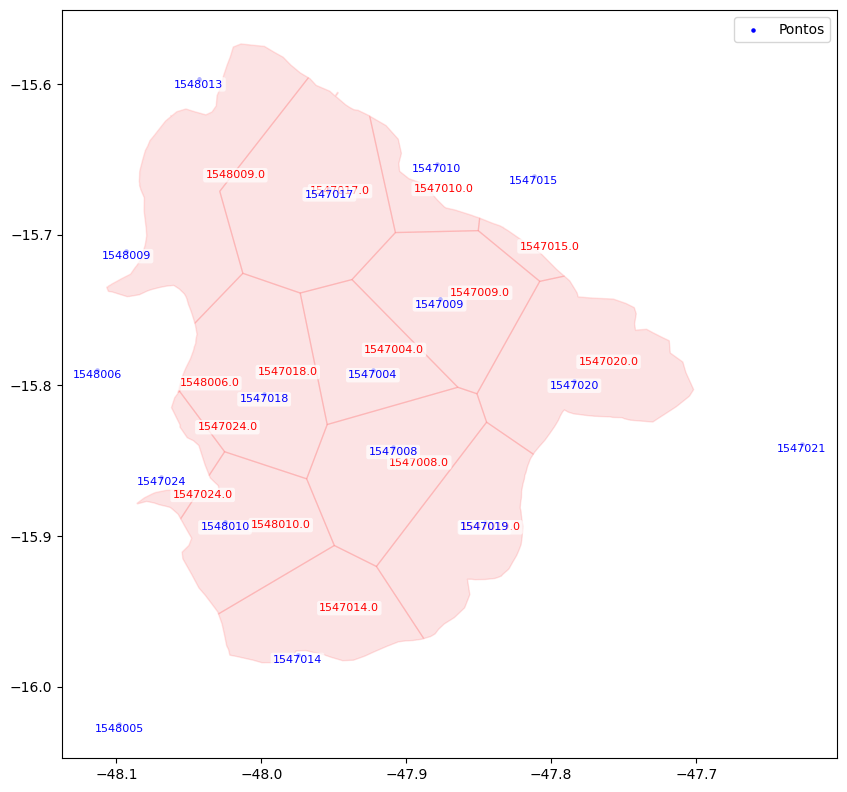

1994


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


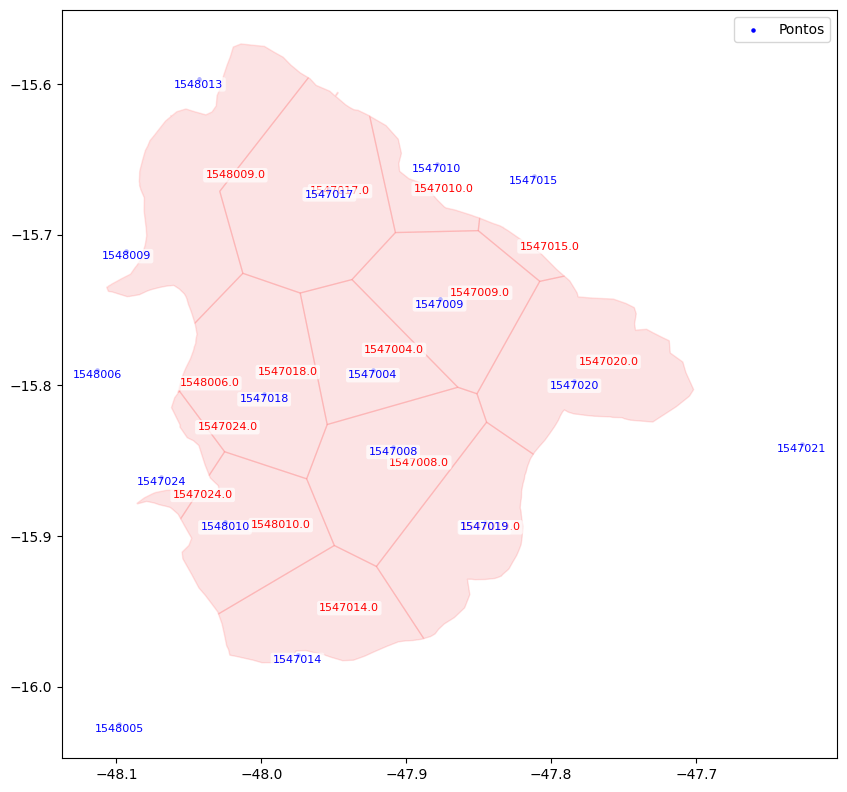

1995


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


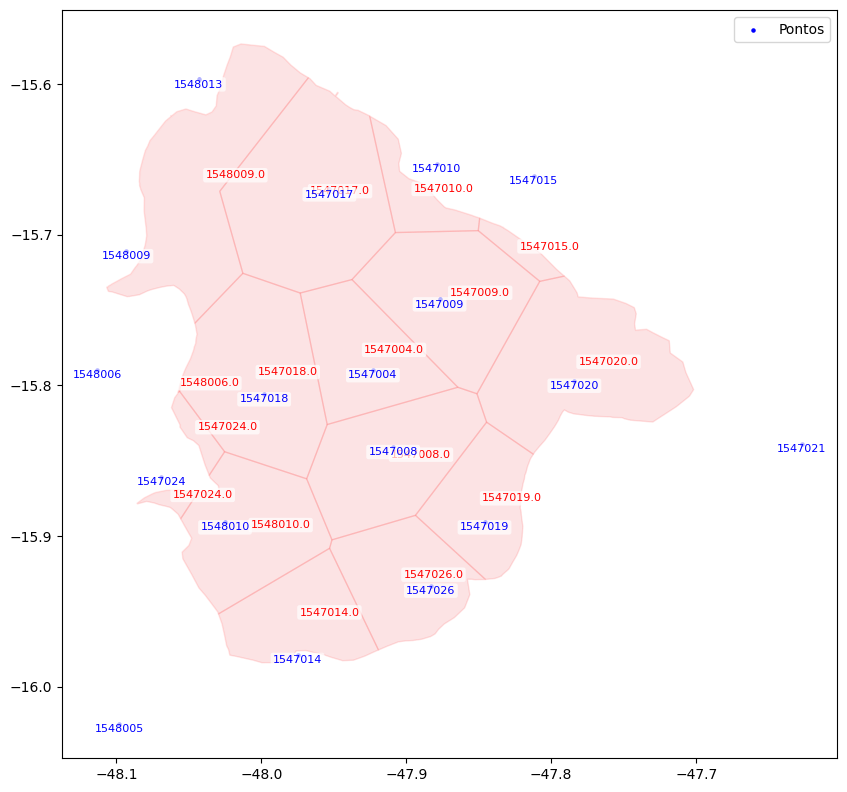

1996


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


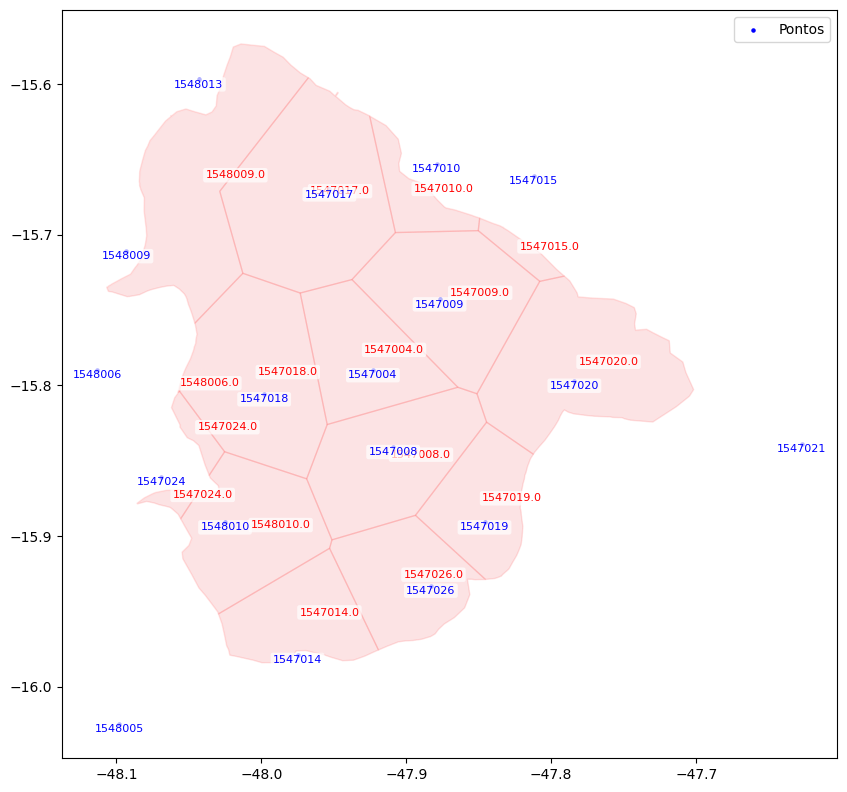

1997


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


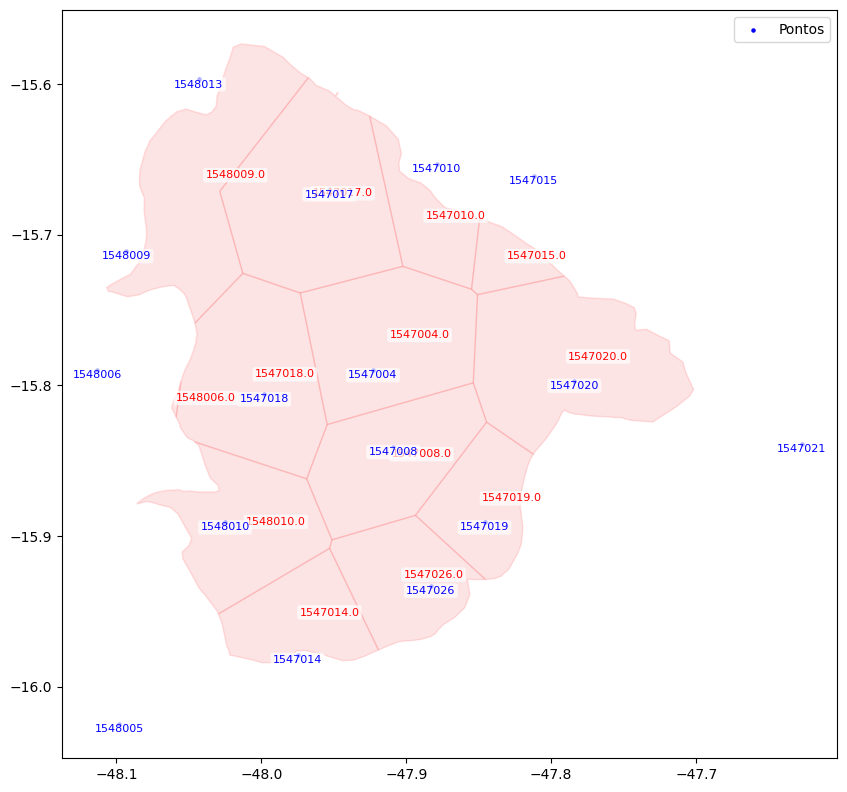

1998


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


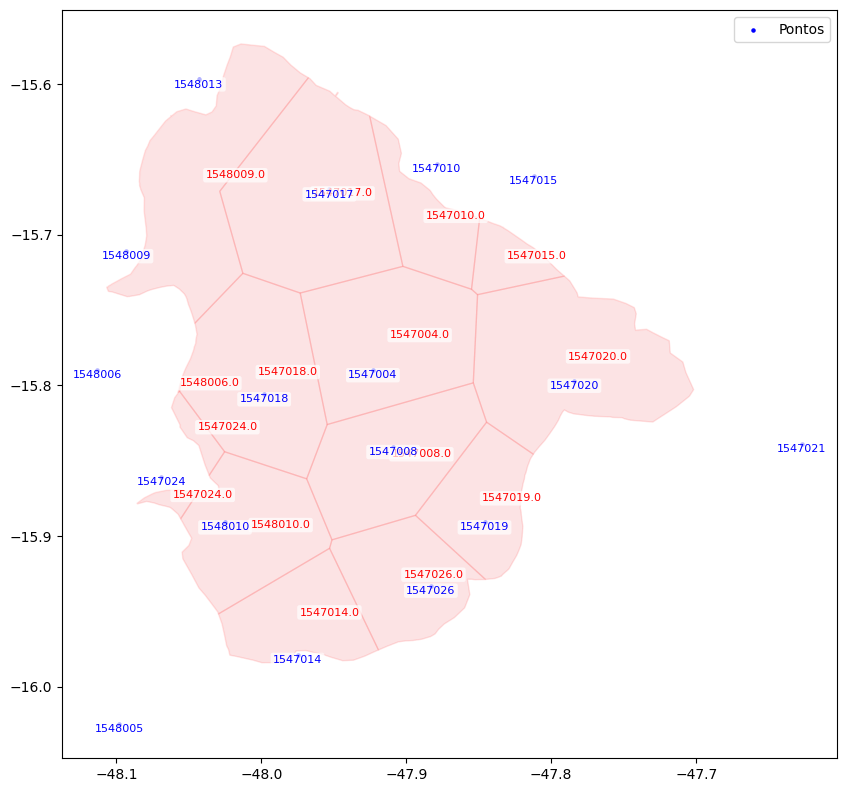

1999


/tmp/ipykernel_1232/1799334754.py:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


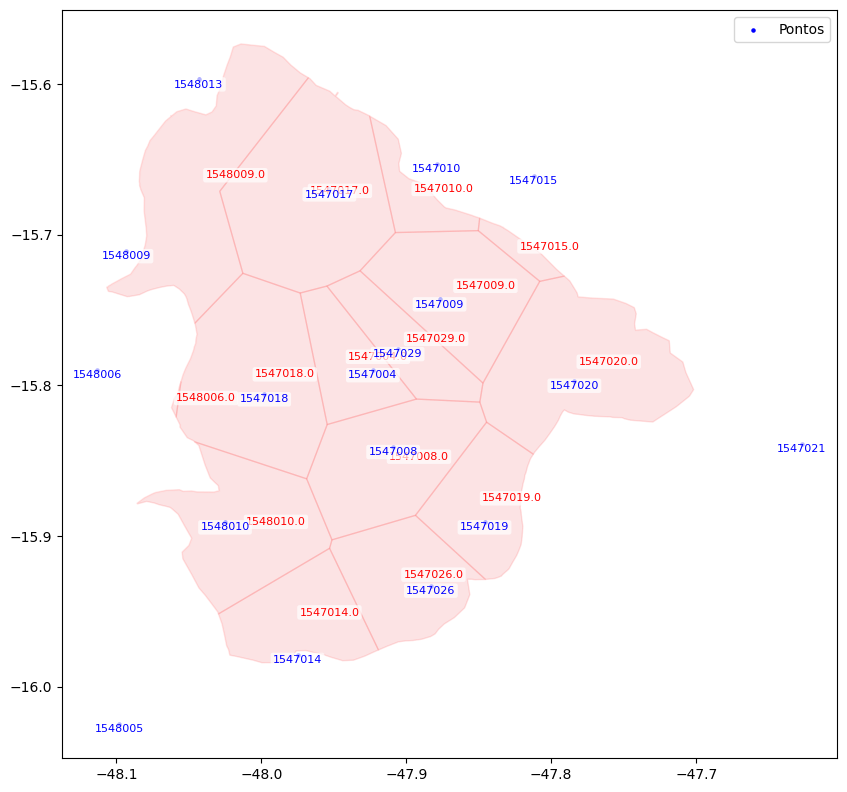

In [22]:
for year in years:
    if int(year) in range(1985, 2000):
        bh_voronoi = gpd.read_file(f"./dados_pluviometricos/{year}/climate_zone_voronoi.geojson")
        gdf_estacoes = gpd.read_file(f"./dados_pluviometricos/{year}/climate_zone_points.geojson")
        print(year)
        fig, ax = plt.subplots(figsize=(10, 10))
      #  gdf_bbox.plot(ax=ax, edgecolor='black', alpha=0.05)
        bh.plot(ax=ax, edgecolor='red', alpha=0.01)
        bh_voronoi.plot(ax=ax, facecolor='red', edgecolor='red', alpha=0.1, label='Voronoi Polygons')
        gdf_estacoes.plot(ax=ax, color='blue', markersize=5, label='Pontos')
        
        # Adicionando rótulos para os polígonos de Voronoi
        for idx, row in bh_voronoi.iterrows():
            centroid = row['geometry'].centroid
            ax.text(centroid.x, centroid.y, row['EstacaoCodigo'], 
                   fontsize=8, ha='left', va='bottom', color='red',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Adicionando rótulos para os pontos das estações
        for idx, row in gdf_estacoes.iterrows():
            ax.text(row.geometry.x, row.geometry.y, row['EstacaoCodigo'], 
                   fontsize=8, ha='center', va='top', color='blue',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        plt.legend()
        plt.show()

In [87]:
1988, 1989, 1990 2011, 2012, 2014

In [88]:
gdf_estacoes = gpd.read_file(f"./dados_pluviometricos/{year}/climate_zone_points.geojson")
    
coords = np.array([(point.x, point.y) for point in gdf_estacoes.geometry])
vor = Voronoi(coords)
polygons = voronoi_polygons(vor, bbox)
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons).set_crs(4674)
dif_bbox_vor = gpd.overlay(gdf_bbox, gdf_voronoi, how = "difference").explode()
all_vor = gpd.GeoDataFrame(pd.concat([gdf_voronoi, dif_bbox_vor]))
bh_voronoi = gpd.overlay(bh_buf_30[["geometry"]], all_vor, how = "intersection")
gdf_voronoi_est = bh_voronoi.sjoin(gdf_estacoes, how = "left").drop("index_right", axis = 1)
gdf_voronoi_est = gdf_voronoi_est.explode().reset_index(drop=True)

<Axes: >

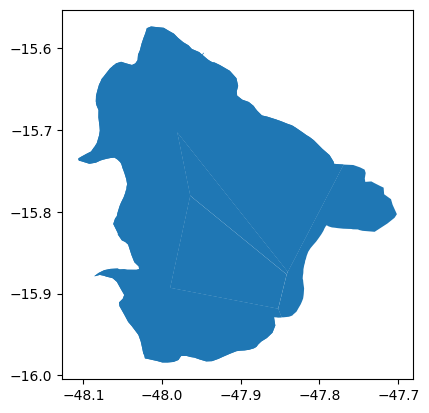

In [89]:
gdf_voronoi_est.plot()

In [ ]:

    
    
    
    bh_voronoi = gpd.overlay(bh_buf_30[["geometry"]], gdf_voronoi_est, how = "intersection")
    bh_voronoi.to_file(f"./dados_pluviometricos/{year}/climate_zone_voronoi.geojson")
   # print(len(bh_voronoi), len(list(bh_voronoi.EstacaoCodigo.unique())))
    rasterize_polygons(bh_voronoi.to_crs(31983), 'EstacaoCodigo', f"./dados_pluviometricos/{year}/climate_zone.tif")